In [1]:
from pathlib import Path
import requests
from PIL import Image
import re
from bs4 import BeautifulSoup
import yaml
import math

This notebook does 2 things. First, it creates the small images used in the grid of the post. Second, it creates a single composite image to be used in the twitter post. 

The script grabs the cover images from the Reading Challenge page on Goodreads. 
It creates a `.yml` file which you the order per the desired book order. It then creates the individual images and the composite image. 
Note: the images should be roughly 98 x 145-152 pixels. The height needs to be 98.

### Grab the URLs

In [2]:
reading_challenge_url = 'https://www.goodreads.com/user_challenges/20552689'
r = requests.get(reading_challenge_url)

In [3]:
soup = BeautifulSoup(r.content, 'html.parser')

In [4]:
urls = {}
for el in soup.findAll("li", {"class": "bookCoverContainer"}):
    a = el.select_one('a')
    urls[a.img['title']] = a.img['src']

In [5]:
if Path('book_cover_urls.yml').exists():
    print('The book_cover_urls.yml file exists. ' + 
          'Since this may be reorderd (see next step) it is not going to be overwritten. ' + 
          'You need to rename it or manually delete it.')
else:
    with open('book_cover_urls.yml', 'w') as outfile:
        yaml.dump(urls, outfile, default_flow_style=False)

The book_cover_urls.yml file exists. Since this may be reorderd (see next step) it is not going to be overwritten. You need to rename it or manually delete it.


### Manual Reorder
Open `book_cover_urls.yml` and manually ensure order matches the desired order of the book images. 

### Process Images

In [6]:
with open('book_cover_urls.yml', 'r') as file:
    covers = yaml.safe_load(file)

In [7]:
cover_dir = Path() / 'cover_images'
if not cover_dir.exists():
    cover_dir.mkdir()

In [8]:
for ix, c in enumerate(covers.values()):
    r = requests.get(c)
    with open(cover_dir / f'cover_{ix:02d}.jpg', 'wb') as f:
        f.write(r.content)

In [9]:
def merge_images(files, horizontal=True):
    """Merge list images into single row of images, displayed side by side
    :param list of files: path first image file
    :return: the merged Image object
    """
    img = []
    w = []
    h = []
    for f in files:
        if not isinstance(f, Image.Image):
            image = Image.open(f)
        else:
            image = f
        img.append(image)
        (width, height) = image.size
        w.append(width)
        h.append(height)

    if horizontal:
        result_width = sum(w)
        result_height = min(h)
    else:
        result_width = max(w)
        result_height = sum(h)
    
    result = Image.new('RGB', (result_width, result_height), color=(255,255,255,0))
    for ix, image in enumerate(img):
        if horizontal:
            width = sum(w[:ix])
            result.paste(im=image, box=(width, 0))
        else:
            height = sum(h[:ix])
            result.paste(im=image, box=(0, height))
    return result

In [10]:
def create_composite(name, cols):
    files = [f for f in cover_dir.iterdir() if re.match(r'cover_[0-9]{2}.jpg', f.name)]
    files_to_drop = []
    if len(files_to_drop) > 0:
        files = [f for f in files if int(re.search(r'cover_([0-9]{2}).jpg', f.name).group(1)) not in files_to_drop]
    files = sorted(files)

    

    rows = []
    for row in range(math.ceil(len(files) / cols)):
        fls = files[cols * row:cols * row + cols]
        if len(fls) > 0:
            rows.append(merge_images(fls, True))
    out = merge_images(rows, False)
    out.save(name)
    return out

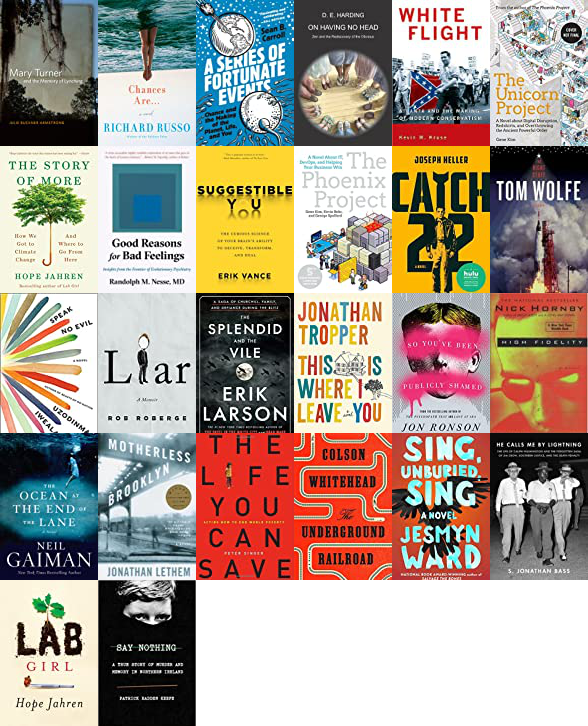

In [11]:
columns = 6
create_composite('composite.png', columns)

In [12]:
blanks_needed = columns * math.ceil(len(covers) / columns) - len(covers)
for ix in range(len(covers), len(covers) + blanks_needed):
    Image.new('RGB', (98, 150), color=('#EAEAEA')).save(cover_dir / f'cover_{ix:02d}.jpg')

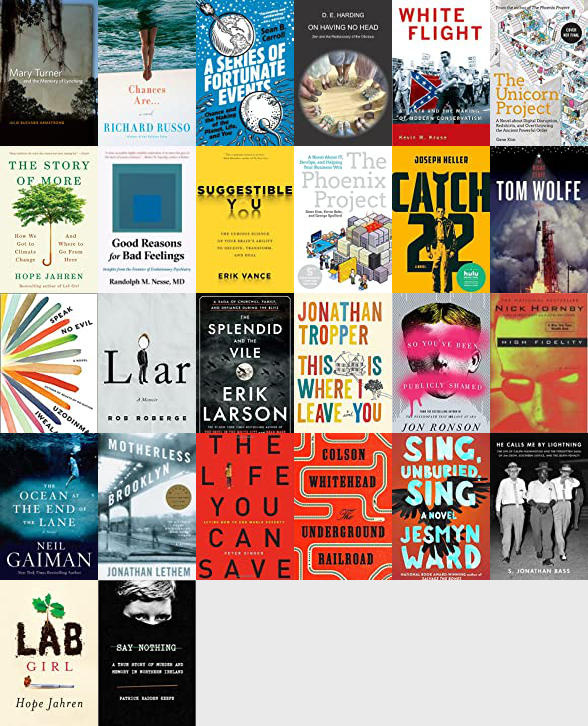

In [13]:
create_composite('composite-filled.png', columns)